In [84]:
#!pip install control

import control as ct
import numpy as np
import matplotlib.pyplot as plt
import os

cwd = os.getcwd()
plot_path = os.path.join(cwd, 'plots')

# Electrical properties #
This piece evaluates what capacitance in the transimpedance amplifier we should probably use.
This is done based on the calculated C_{i,photodiode} = 1.1e-3 pF or C_{i,photodiode} = 100 pF. It is important to evaluate both cases.
The stray capacitance of the transimpedance amplifier cicuit is estimated to be C_{i,TIA} = 100 pF as well. A motivation for this is Amunds life experience.
C_f is what will be optimized for.

In [85]:

Rf = 1000 # Resistance in ohms
Cf = 50*(10**-9) # Capacitance in farads
Ci_amp = 100*(10**-12) # Stray capacitance in farads (amplifier system)
Ci_sun_sensor = 1.1*1e-15 # Stray capacitance of the photo diode (sun sensor system)
Ci = Ci_sun_sensor + Ci_amp

i_i = 0.0028 # Initial current in amperes

A0 = 10**5 # Open loop Gain of the amplifier
f0 = 100#Open loop cutoff frequency in hertz

omega0 = 2 * np.pi * f0 # Open loop cutoff frequency in radians per second

In [86]:
# Transfer function of the system
def transferfunction(Cf,A0,omega0,Ci,Rf):
    top = - A0 * omega0 /(Ci + Cf) / Rf # Topside of the transfer function
    bottom = [1, (1+ omega0 * Rf * (Ci + (1+ A0)* Cf))/((Ci+Cf)*Rf), omega0*(1+A0)/((Ci+Cf)*Rf)] # Denominator of the transfer function
    tf = ct.tf(top, bottom) # Transfer function of the system
    print("Transfer function: ", tf)
    return tf
tf = transferfunction(Cf,A0,omega0,Ci,Rf)

Transfer function:  <TransferFunction>: sys[69]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


         -1.254e+12
-----------------------------
s^2 + 6.273e+07 s + 1.254e+12



In [87]:
# Calculate the compensation capacitance as a function of the other system parameters
def find_Cf(A0,omega0,Ci,Rf):
    c = 1 -  omega0*Ci*Rf*(1 + 3*A0) + (omega0*Rf*Ci)**2
    b = -omega0*Rf*(1 + A0) + 2*(omega0*Rf)**2*Ci*(1 + A0)
    a = (omega0*Rf*(1 + A0))**2
    disc = b**2 - 4*a*c
    roots = (-b - np.sqrt(disc))/(2*a) , (-b + np.sqrt(disc))/(2*a)
    return roots

roots = find_Cf(A0,omega0,Ci,Rf)

print("The roots for the capacitance are: \n",roots, "\n It is probably wisest to pick the largest")
Cf_opt = roots[1]
tf_opt = transferfunction(Cf_opt,A0,omega0,Ci,Rf)
#Obviously I cannot do basic algebra since this answer makes no sense

The roots for the capacitance are: 
 (-5.975324234372856e-11, 7.566657749756655e-11) 
 It is probably wisest to pick the largest
Transfer function:  <TransferFunction>: sys[70]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


         -3.577e+14
-----------------------------
s^2 + 3.276e+07 s + 3.577e+14



In [88]:
#Check whether the condition holds
def bessel_condition(Cf,A0,omega0,Ci,Rf):
    fraction = (4*omega0*(1+A0)*(Ci+Cf)*Rf)/(1 + Rf*omega0*(Ci+(1+A0)*Cf))**2
    print(fraction)
    return fraction <= 4/3

print(f"Cf = {Cf} bessel condition", bessel_condition(Cf_opt,A0,omega0,Ci,Rf))
print(f"Cf = {Cf_opt} bessel condition",bessel_condition(Cf,A0,omega0,Ci,Rf))
#It does

1.3333333333333328
Cf = 5.0000000000000004e-08 bessel condition True
0.0012749614563546516
Cf = 7.566657749756655e-11 bessel condition True


## Cf = 50 nF ##
testing Amunds first proposal

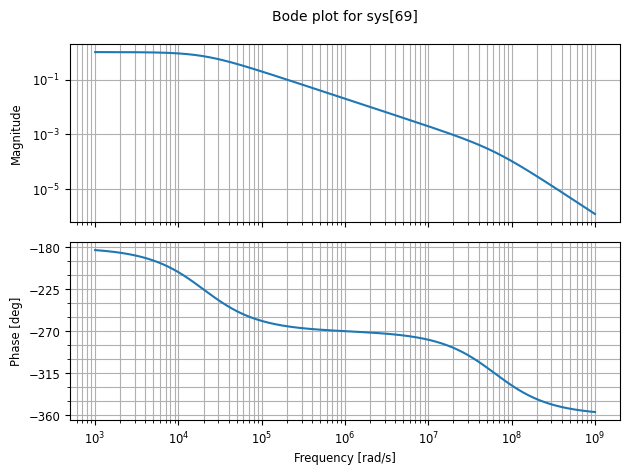

In [89]:
initial_capacitance_bode = os.path.join(plot_path, "initial_capacitance_bode.png")
ct.bode(tf) # Bode plot of the transfer function
plt.savefig(initial_capacitance_bode)
plt.show()

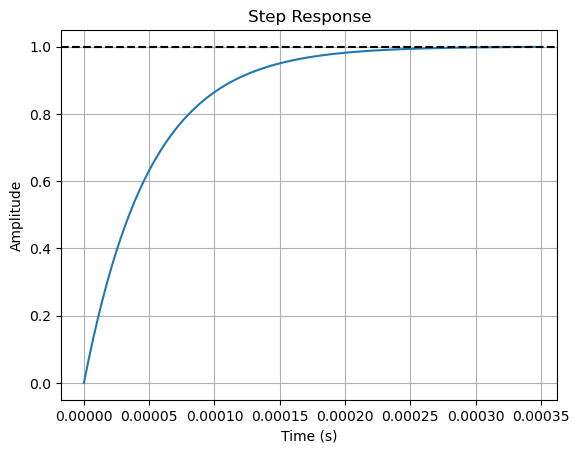

{'RiseTime': 0.0001116404204955221,
 'SettlingTime': 0.00019885949900764875,
 'SettlingMin': -0.9999900000999992,
 'SettlingMax': -0.906700844014681,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 0.9989896910567487,
 'PeakTime': 0.0003453875509080215,
 'SteadyStateValue': -0.9999900000999992}

In [90]:
# t = np.linspace(0, 1, 1000) # Time vector for the step response

t, y = ct.step_response(tf ) # Step response of the system
plt.plot(t, -y) # Plotting the step response
plt.title("Step Response")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.axhline(y=1, color='k', linestyle='--')
plt.show()
# show step response charactersistics
S = ct.step_info(tf)
S

## Cf_opt = 75.6 pF ##
Assuming the photdiode introduces a stray C of 1.1 e-3 pF.
This capacitor is about 1000 times smaller than the previous version. It is a consequence of trying to approach a bessel system and is a lower bound on capacitance. If we go lower, expect noise, ringing and general bad stuff.

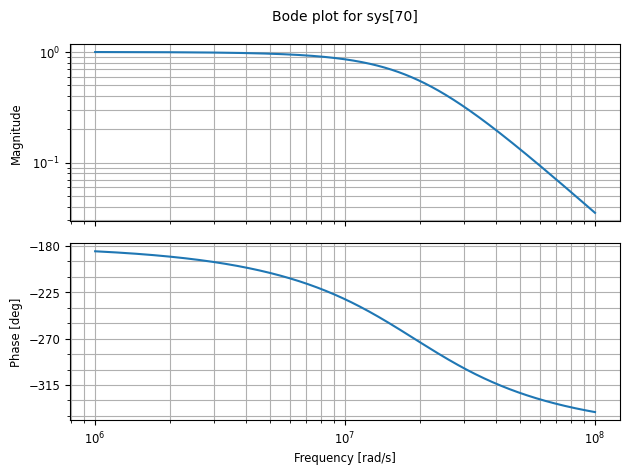

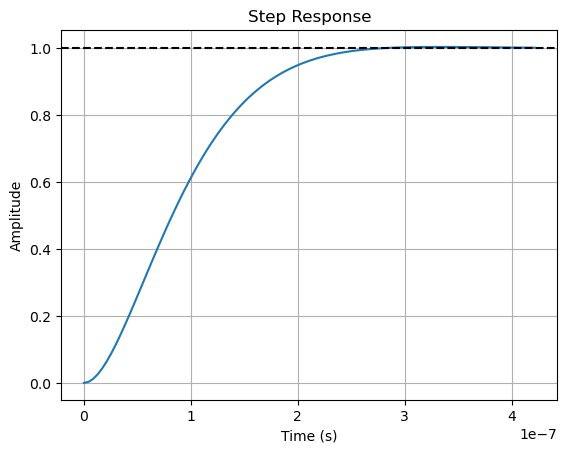

{'RiseTime': 1.4484511679463146e-07,
 'SettlingTime': 2.3004812667382644e-07,
 'SettlingMin': -1.0043233739353608,
 'SettlingMax': -0.905823846677526,
 'Overshoot': 0.4333417169100051,
 'Undershoot': 0,
 'Peak': 1.0043233739353608,
 'PeakTime': 3.3229173852886045e-07,
 'SteadyStateValue': -0.999990000099999}

In [91]:
optimized_capacitance_bode = os.path.join(plot_path, "optimized_capacitance_bode.png")
ct.bode(tf_opt) # Bode plot of the transfer function
plt.savefig(optimized_capacitance_bode)
plt.show()


t_opt, y_opt = ct.step_response(tf_opt ) # Step response of the system
plt.plot(t_opt, -y_opt) # Plotting the step response
plt.title("Step Response")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.axhline(y=1, color='k', linestyle='--')
plt.show()
#Frequency behavior quite good
S = ct.step_info(tf_opt)
S
#there is an ever so slight overshoot in the response here. almost 0.5%

## Cf_opt = 105 pF ##
Assuming the photdiode introduces a stray C of 100 pF and the TIA a stray of 100 pF.

0.001277506210468914
Cf = 1.0469827549436106e-10 bessel condition True
Transfer function:  <TransferFunction>: sys[85]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


         -3.069e+14
----------------------------
s^2 + 3.702e+07 s + 3.07e+14



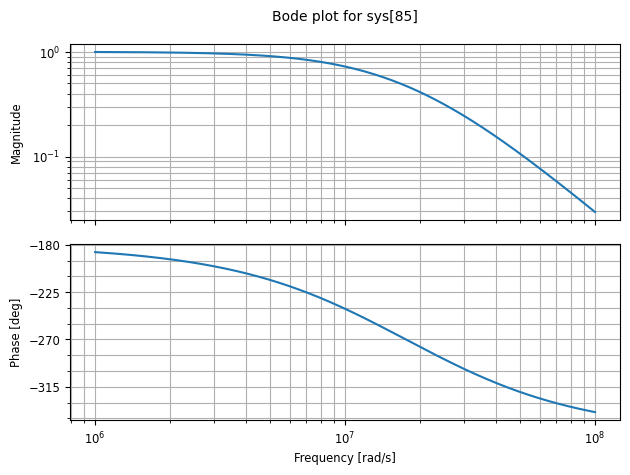

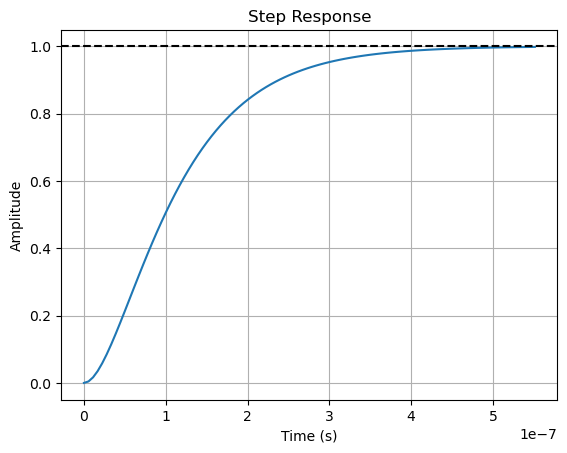

{'RiseTime': 2.0596203330723533e-07,
 'SettlingTime': 3.72958276529318e-07,
 'SettlingMin': -0.999990000099999,
 'SettlingMax': -0.9010143202095959,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 0.9979428050113186,
 'PeakTime': 5.510876026328729e-07,
 'SteadyStateValue': -0.999990000099999}

In [101]:
Ci2 = 100*1e-12 + Ci_amp
roots2 = find_Cf(A0,omega0,Ci2,Rf)
Cf_opt2 = roots2[1]
print(f"Cf = {Cf_opt2} bessel condition",bessel_condition(Cf,A0,omega0,Ci2,Rf))

tf_opt2 = transferfunction(Cf_opt2,A0,omega0,Ci,Rf)
optimized_capacitance_bode_v2 = os.path.join(plot_path, "optimized_capacitance_bode_v2.png")
ct.bode(tf_opt2) # Bode plot of the transfer function
plt.savefig(optimized_capacitance_bode_v2)
plt.show()


t_opt2, y_opt2 = ct.step_response(tf_opt2 ) # Step response of the system
plt.plot(t_opt2, -y_opt2) # Plotting the step response
plt.title("Step Response")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.axhline(y=1, color='k', linestyle='--')
plt.show()
#frequency behavior is not bad
S = ct.step_info(tf_opt2)
S

# SIMULATION #
Room for simulation
It is good to run this for a couple of options of Cf

In [115]:
import sim_funcs as sf
# Define some typical geometry and values
f = 1366# w/m^2
b = 1e-2# baffle hole size
d = 5e-2 #cell size
h = 5e-3 #baffle eight


def moving_sun(t):
    # The sun is moving in circles on the sky
    b_t =  0.1 * np.cos(0.1* np.pi * t)*np.pi
    a_t = 0.1 * np.sin(0.1* np.pi * t)*np.pi
    return b_t*180/np.pi, a_t*180/np.pi

In [116]:
# Model the system after current input
time = np.linspace(0,100,1000)
b_t, a_t = moving_sun(time)
# when someone figures out how to do boolian shenanigans on massive arrays,
# This can become so much faster
l_1, l_2, l_3, l_4, l_max = [],[],[],[],[]
for i,t in enumerate(time):
    l_1_i, l_2_i, l_3_i, l_4_i, l_max_i = sf.illumination(f, b, d, h, a_t[i], b_t[i])
    l_1.append(l_1_i)
    l_2.append(l_2_i)
    l_3.append(l_3_i)
    l_4.append(l_4_i)
    l_max.append(l_max_i)

l_1, l_2, l_3, l_4, l_max = np.array(l_1), np.array(l_2), np.array(l_3), np.array(l_4), np.array(l_max)
#calculate currents
I1, I2, I3, I4, = sf.power_to_current(l_1, l_2, l_3, l_4, l_max)

# The output data of the response is the property y of TimeResponseData
Q1, Q2, Q3, Q4 = (ct.forced_response(tf_opt, time, I1).y * Rf,
                  ct.forced_response(tf_opt, time, I2).y * Rf,
                  ct.forced_response(tf_opt, time, I3).y * Rf,
                  ct.forced_response(tf_opt, time, I4).y * Rf)
# Calculate angles using a 12 bit system and a ref voltage of 3.3
V1_frac, V2_frac, V3_frac, V4_frac = (sf.ADC_DAC(Q1, 12, 3.3), sf.ADC_DAC(Q2, 12, 3.3),
                                      sf.ADC_DAC(Q3, 12, 3.3), sf.ADC_DAC(Q4, 12, 3.3))
alpha, beta = sf.sun_angles(Q1=V1_frac,Q2=V2_frac,Q3=V3_frac,Q4=V4_frac)

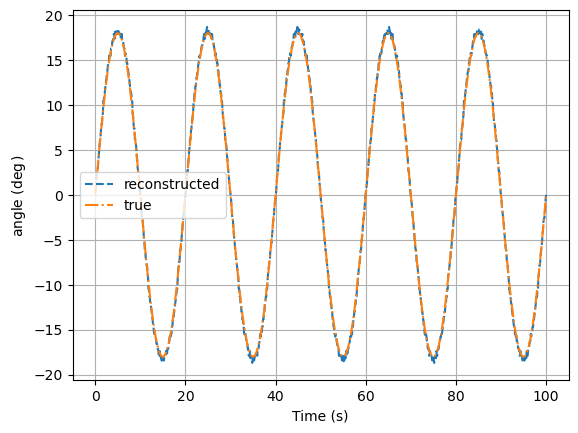

In [117]:
plt.plot(time, alpha.reshape(-1,), linestyle="--", label = "reconstructed")
plt.plot(time, a_t, linestyle="-.",label = "true")
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("angle ($\deg$)")
plt.show()

If you are here, I hope you read through most of the doc and partially understand it. The last part is quite important as it specifies our system performance. Consider doing some statistics with is.
Also note that the sunsensor geometry is not final. The system is also quite sensitive to sunsensor geometry variations as for some combinations of b,d,h, the system may be insensitive to large angles.
When using this, please consider that we need several scenarios for Cf.
